![](https://rusderevnya.ru/upload/iblock/f19/f197a08720322cf72267644bee5d19d2.jpg)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# Import

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import re
from datetime import datetime
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
pd.set_option('display.max_columns', 50)

In [ ]:
df_train.info()

In [ ]:
df_train.head(5)

In [ ]:
df_test.info()

In [ ]:
df_test.head(5)

In [ ]:
sample_submission.head(5)

In [ ]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [ ]:
data.info()

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [ ]:
data.sample(5)

In [ ]:
data.Reviews[1]

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Рассмотрим признаки датасета по отдельности

#### 1. Restaurant_id - порядковый номер ресторана

In [ ]:
data.loc[:, ['Restaurant_id']].info()
display(data.Restaurant_id.value_counts())

нет пропусков но есть повторяющиеся значения - можно сделать вывод что это сеть ресторанов. Добавим новый признак в нашу модель - представим что 0 будет соответствовать уникальному ресторану (id = 1) а 1 будет отвечать сети ресторанов (id > 1)

In [ ]:
restaurant_chain = data['Restaurant_id'].value_counts()[data['Restaurant_id'].value_counts() > 1].index.tolist()
data['restaurant_chain'] = data[data['Restaurant_id'].isin(restaurant_chain)].Restaurant_id.apply(lambda x: 1) # заполняем единицей
data['restaurant_chain'] = data['restaurant_chain'].fillna(0) # заполняем остаток 0
data['restaurant_chain'].describe()

#### 2. City

In [ ]:
data.City.value_counts()

In [ ]:
data['City'].value_counts(ascending=True).plot(kind='barh')

In [ ]:
# города закодируем с помощью One-Hot Encoding и сохраним названия городов - возможно, используем позже
data['City_name'] = data['City']
data = pd.get_dummies(data, columns=['City'], dummy_na=True)

In [ ]:
data.head(2)

#### 3. Cuisine Style - виды кухни которые предствлены в ресторане

In [ ]:
display(data['Cuisine Style'].describe())
display(data['Cuisine Style'].isna().value_counts())

In [ ]:
cuisine_style = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'") # применим регулярные выражения для поиска наиболее частого встречающегося варианта
cuisine_style.explode().value_counts()

есть пропуски, наиболее частое встречающиеся значение 'Vegetarian Friendly'. Создадим новый признак на основании этого куда положим все виды кухни списком, пропуски заполним 'European' - как самую обобщающую кухню. Она включает и 'Vegetarian Friendly' и множество остальных

In [ ]:
# заполним пропуски
#data['Cuisine Style'].fillna('European')
data['Cuisine Style'] = data['Cuisine Style'].fillna('European')

In [ ]:
# выполним преобразование данных
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: str(x).replace('[',''))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: str(x).replace(']',''))
data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: str(x).replace(' ',''))
data['cuisine_style'] = data['Cuisine Style'].apply(lambda x:x.split(','))

In [ ]:
data['cuisine_style'].explode().value_counts()

In [ ]:
# Создадим признак, содержащий количество кухонь, представленных в ресторане
data['cuisine_count'] = data['cuisine_style'].apply(lambda x: len(x))

In [ ]:
data.info()

#### 4. Price Range

In [ ]:
display(data['Price Range'].describe())
display(data['Price Range'].explode().value_counts())

Есть пропуски - заполним наиболее частым значением, приведем признак к числовому значения через словарь 


In [ ]:
#data['Price Range'] = data['Price Range'].fillna('$$ - $$$')
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}

# выполним преобразование
data['Price Range'].replace(price_dict, inplace=True)

In [ ]:
data['Price Range'].describe()

Есть пропуски - более 75% из заполненной информации имеют средний параметр цены поэтому заполняем пропуски (2)


In [ ]:
data['Price Range'] = data['Price Range'].fillna(2)

#### 5. Number of Reviews


In [ ]:
data['Number of Reviews'].isna().value_counts() # есть пропуски 

In [ ]:
median = data['Number of Reviews'].median() # посчитаем медиану и заполним все NA
data['Number of Reviews'] = data['Number of Reviews'].apply (lambda x: median if pd.isnull(x) else x)

In [ ]:
data['Number of Reviews'].isna().value_counts()

#### 6. Reviews

Сначала заполним пропуски

In [ ]:
data['Reviews'] = data['Reviews'].fillna('[[], []]')

На основе дат добавим признаки количества дней между двумя последними отзывами и количество дней с момента последнего отзыва

In [ ]:
pattern = re.compile('\'\d+\/\d+\/\d+\'')
dates = data['Reviews'].apply(pattern.findall)
# врeменные признаки
data['date1'] = pd.to_datetime(dates.apply(lambda x: x[0] if len(x) > 0 else None))
data['date2'] = pd.to_datetime(dates.apply(lambda x: x[1] if len(x) > 1 else None))

display(data.loc[:, ['date1', 'date2']].sample(5))

Посчитаем количество дней с последней даты отзыва и количество дней между двумя отзывами

In [ ]:
def days_since_last_review(r):
    '''
    Считает количество дней с последней даты отзыва. Учитывает отсутствие одной из дат и пропуск (возвращает
    0 в последнем случае)
    '''
    datetime_now = datetime.now();
    if pd.notna(r.date1) and pd.notna(r.date2):
        if r.date1 > r.date2:
            return (datetime_now - r.date1).days
        else:
            return (datetime_now - r.date2).days
    else:
        if pd.notna(r.date1):
            return (datetime_now - r.date1).days
        if pd.notna(r.date2):
            return (datetime_now - r.date2).days        
    return 0 

def reviews_days_delta(r):
    '''
    Считает количество дней между двумя отзывами. Учитывает отсутствие (одной из) дат - возвращает 0 в данном
    случае.
    '''
    if pd.notna(r.date1) and pd.notna(r.date2):
        return abs((r.date1 - r.date2).days)
    else:
        return 0


Новые признаки: количество дней между двумя последними отзывами и количество дней со времени последнего отзыва


In [ ]:
data['Days_Since_Review'] = data.apply(lambda row: days_since_last_review(row), axis=1)
data['Reviews_Days_Delta'] = data.apply(lambda row: reviews_days_delta(row), axis=1)
# удаляем временные признаки
data.drop(['date1', 'date2'], inplace=True, axis=1)

In [ ]:
data.sample(2)

#### 7. cuisine_style

рассмотрим уже созданный признак cuisine_style и создадим новые признаки этом основании - представим что каждому виду кухни будет соответствовать 1, при отсутствии этого вида кухни 0

In [ ]:
cuisine_style = data['cuisine_style']
cuisine_style

In [ ]:
# Поскольку в столбце списки, с начала получаем перечень уникальных значений

cuisines = set()

for row in cuisine_style:
    if type(row) == float:
        continue
    for cuisine in row:
        cuisines.add(cuisine)

# Затем создаем столбцы для каждой кухни

def find_item(cell):
    if item in cell:
        return 1
    return 0

for item in cuisines:
    data[item] = data['cuisine_style'].apply(find_item)

In [ ]:
data.info(5)

#### 8. URL_TA и ID_TA

In [ ]:
data['URL_TA'].describe() # предствляет собой страницы ресторанов с трипэдвайзера - в модели учавствовать не будет (хотя интересно что есть повторяющееся значения)

In [ ]:
data['ID_TA'].describe() # предствляет собой ID ресторана на том же самом сайте - в модели учавствовать не будет 

#### 9. Ranking

In [ ]:
display(data.Ranking.describe()) # пропусков нет - но сами значения достаточно большие 

Ranking полезнее рассматривать в контексте населения города и количества ресторанов в городе - создим новые признаки для этого

In [ ]:
#население территории города (metro area) - источник: wiki
city_population = {'Paris':13024, 'Stockholm':2391, 'London':14257, 
                   'Berlin':6144, 'Munich':5991, 'Oporto':1721,
                   'Milan':4336, 'Bratislava':659, 'Vienna':2600, 
                   'Rome':4342, 'Barcelona':5474, 'Madrid':6791,
                   'Dublin':1417, 'Brussels':2500, 'Zurich':415, 
                   'Warsaw':3100, 'Budapest':3011, 'Copenhagen':2057,
                   'Amsterdam':2480, 'Lyon':2323, 'Hamburg':5107, 
                   'Lisbon':2827, 'Prague':2677, 'Oslo':1588,
                   'Helsinki':1525, 'Edinburgh':901, 'Geneva':201, 
                   'Ljubljana':537, 'Athens':2928,'Luxembourg':633, 
                   'Krakow':1752}

#количество ресторанов в городе
rest_per_city = data.City_name.value_counts().to_dict()

data['Ranking_Rest_Num'] = data.apply(lambda r: (r['Ranking'] / rest_per_city[r.City_name]), axis=1)
data['Ranking_Population'] = data.apply(lambda r: (r['Ranking'] / city_population[r.City_name]), axis=1)
data.sample(5)

### Посмотрим распределение признака Ranking

In [ ]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

In [ ]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

In [ ]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

In [ ]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.


### Посмотрим распределение целевой переменной

In [ ]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

Наибольшее количество ресторанов имеют рейтинг 4

In [ ]:
# Построим боксплоты для рейтинга
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(x = 'City', y = 'Rating',data=df_train)
plt.xticks(rotation=45)
ax.set_title('Boxplot for City')
plt.show()

Рестораны Милана заметно отличаются распределением оценок и наличием оценок = 5 а рестораны Рима тем что нет оценок ниже 3

### Посмотрим распределение целевой переменной относительно признака

In [ ]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

In [ ]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [ ]:
#plt.rcParams['figure.figsize'] = (15,10)
#sns.heatmap(data.drop(['sample'], axis=1).corr(),cmap="BrBG")
#data.drop(['sample'], axis=1).corr()

plt.rcParams['figure.figsize'] = (15,10)
data_cor = data[['Cuisine Style', 'Ranking', 'Price Range', 'Number of Reviews', 'Rating', 'cuisine_count',
                  'Days_Since_Review', 'Reviews_Days_Delta', 'Ranking_Rest_Num', 'Ranking_Population']]
sns.heatmap(data_cor.corr(), annot=True, cmap='BrBG')

 По графику видно, что слишком скоррелированных с целевой переменной признаков у нас нет

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [6]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [7]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['URL_TA','ID_TA',], axis = 1, inplace=True)
    
    
    # ################### 2. NAN ############################################################## 
    # добавим новый признак в нашу модель - 0 будет соответствовать уникальному ресторану (id = 1) 
    # а 1 будет отвечать сети ресторанов (id > 1)
    restaurant_chain = df_output['Restaurant_id'].value_counts()[df_output['Restaurant_id'].value_counts() > 1].index.tolist()
    df_output['restaurant_chain'] = df_output[df_output['Restaurant_id'].isin(restaurant_chain)].Restaurant_id.apply(lambda x: 1)
    df_output['restaurant_chain'] = df_output['restaurant_chain'].fillna(0) # заполняем остаток 0

    # выполним преобразование данных 'Cuisine Style'    
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('European')
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: str(x).replace('[',''))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: str(x).replace(']',''))
    df_output['Cuisine Style'] = df_output['Cuisine Style'].apply(lambda x: str(x).replace(' ',''))
    df_output['cuisine_style'] = df_output['Cuisine Style'].apply(lambda x:x.split(','))

    # заполним наиболее частым значением 'Price Range'
    df_output['Price Range'] = df_output['Price Range'].fillna(2)
    median = df_output['Number of Reviews'].median() # посчитаем медиану и заполним все NA
    df_output['Number of Reviews'] = df_output['Number of Reviews'].apply (lambda x: median if pd.isnull(x) else x)
    df_output['Reviews'] = df_output['Reviews'].fillna('[[], []]')
    
        
    # ################### 3. Encoding ############################################################## 
    # города закодируем с помощью One-Hot Encoding и сохраним названия городов - возможно, используем позже
    df_output['City_name'] = df_output['City']
    df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True)

    # Создадим признак, содержащий количество кухонь, представленных в ресторане
    df_output['cuisine_count'] = df_output['cuisine_style'].apply(lambda x: len(x))
    
    # рассмотрим уже созданный признак cuisine_style и создадим новые признаки этом основании
    # представим что каждому виду кухни будет соответствовать 1, при отсутствии этого вида кухни 0
    cuisine_style = df_output['cuisine_style']
    cuisines = set()
    for row in cuisine_style:
        if type(row) == float:
            continue
        for cuisine in row:
            cuisines.add(cuisine)

    # Затем создаем столбцы для каждой кухни
    def find_item(cell):
        if item in cell:
            return 1
        return 0

    for item in cuisines:
        df_output[item] = df_output['cuisine_style'].apply(find_item)

 
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # выполним преобразование через словарь price_dict
    price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
    df_output['Price Range'].replace(price_dict, inplace=True)

    # На основе дат добавим признаки количества дней между двумя последними отзывами и количество дней с момента последнего отзыва
    pattern = re.compile('\'\d+\/\d+\/\d+\'')
    dates = df_output['Reviews'].apply(pattern.findall)
    # врeменные признаки
    df_output['date1'] = pd.to_datetime(dates.apply(lambda x: x[0] if len(x) > 0 else None))
    df_output['date2'] = pd.to_datetime(dates.apply(lambda x: x[1] if len(x) > 1 else None))
    def days_since_last_review(r):
        '''
        Считает количество дней с последней даты отзыва. Учитывает отсутствие одной из дат и пропуск (возвращает
        0 в последнем случае)
        '''
        datetime_now = datetime.now();
        if pd.notna(r.date1) and pd.notna(r.date2):
            if r.date1 > r.date2:
                return (datetime_now - r.date1).days
            else:
                return (datetime_now - r.date2).days
        else:
            if pd.notna(r.date1):
                return (datetime_now - r.date1).days
            if pd.notna(r.date2):
                return (datetime_now - r.date2).days        
        return 0 

    def reviews_days_delta(r):
        '''
        Считает количество дней между двумя отзывами. Учитывает отсутствие (одной из) дат - возвращает 0 в данном
        случае.
        '''
        if pd.notna(r.date1) and pd.notna(r.date2):
            return abs((r.date1 - r.date2).days)
        else:
            return 0

    df_output['Days_Since_Review'] = df_output.apply(lambda row: days_since_last_review(row), axis=1)
    df_output['Reviews_Days_Delta'] = df_output.apply(lambda row: reviews_days_delta(row), axis=1)    
    
    #население территории города
    city_population = {'Paris':13024, 'Stockholm':2391, 'London':14257, 
                       'Berlin':6144, 'Munich':5991, 'Oporto':1721,
                       'Milan':4336, 'Bratislava':659, 'Vienna':2600, 
                       'Rome':4342, 'Barcelona':5474, 'Madrid':6791,
                       'Dublin':1417, 'Brussels':2500, 'Zurich':415, 
                       'Warsaw':3100, 'Budapest':3011, 'Copenhagen':2057,
                       'Amsterdam':2480, 'Lyon':2323, 'Hamburg':5107, 
                       'Lisbon':2827, 'Prague':2677, 'Oslo':1588,
                       'Helsinki':1525, 'Edinburgh':901, 'Geneva':201, 
                       'Ljubljana':537, 'Athens':2928,'Luxembourg':633, 
                       'Krakow':1752}

    #количество ресторанов в городе
    rest_per_city = df_output.City_name.value_counts().to_dict()
    df_output['Ranking_Rest_Num'] = df_output.apply(lambda r: (r['Ranking'] / rest_per_city[r.City_name]), axis=1)
    df_output['Ranking_Population'] = df_output.apply(lambda r: (r['Ranking'] / city_population[r.City_name]), axis=1)
    
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['date1', 'date2'], inplace=True, axis=1)

    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [8]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,restaurant_chain,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,...,'Cafe','Seafood','Turkish','French','Fusion','Diner','Romanian','Albanian','Tunisian','Ecuadorean','Colombian','Brazilian','Arabic','Halal','American','Italian','Lebanese','German','CentralEuropean','Vietnamese','Jamaican',Days_Since_Review,Reviews_Days_Delta,Ranking_Rest_Num,Ranking_Population
5753,13.0,2,989.0,0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1233,11,0.012585,0.005437
15436,58.0,3,406.0,1,4.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1364,12,0.118852,0.036524
27474,7105.0,2,185.0,1,3.5,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1272,28,0.987766,0.498352
6226,4032.0,2,31.0,0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1215,11,0.560545,0.282808
27833,3685.0,2,7.0,1,4.5,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1377,93,1.085420,0.673182
33408,5756.0,2,2.0,1,4.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.695434,1.051516
3317,1816.0,2,33.0,0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.258489,0.698462
39781,256.0,2,56.0,1,4.5,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1259,74,0.215852,0.050127
48478,476.0,2,79.0,1,4.0,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1224,20,0.569378,0.335921
1769,2694.0,2,5.0,0,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1301,0,0.995933,0.438477


In [21]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 169 entries, Ranking to Ranking_Population
dtypes: float64(6), int64(131), uint8(32)
memory usage: 53.8 MB


In [22]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [23]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [24]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 168), (40000, 168), (40000, 167), (32000, 167), (8000, 167))

# Model 
Сам ML

In [13]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [14]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [15]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [16]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.203811875


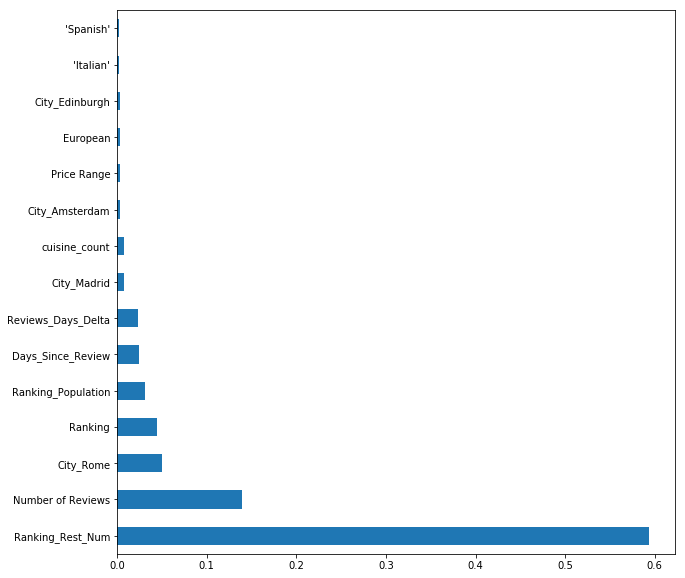

In [17]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [18]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,restaurant_chain,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,City_Budapest,City_Copenhagen,City_Dublin,City_Edinburgh,City_Geneva,City_Hamburg,City_Helsinki,City_Krakow,City_Lisbon,City_Ljubljana,City_London,City_Luxembourg,City_Lyon,City_Madrid,...,'Cafe','Seafood','Turkish','French','Fusion','Diner','Romanian','Albanian','Tunisian','Ecuadorean','Colombian','Brazilian','Arabic','Halal','American','Italian','Lebanese','German','CentralEuropean','Vietnamese','Jamaican',Days_Since_Review,Reviews_Days_Delta,Ranking_Rest_Num,Ranking_Population
4339,965.0,1,137.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1400,7,0.372731,0.222248
7863,5594.0,2,7.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1964,0,2.068022,0.910482
5681,7751.0,2,247.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1256,78,2.032783,1.141364
6440,1000.0,2,36.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1372,375,0.693001,0.384615
3894,3353.0,2,33.0,0.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.239556,0.545736
495,5701.0,2,33.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2.202008,1.312989
3983,11259.0,2,10.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.843320,0.864481
9485,5409.0,2,51.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1746,0,2.089224,1.245739
6176,764.0,2,37.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1248,224,1.115328,1.840964
2918,1745.0,2,44.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1256,190,0.647736,0.402445


In [25]:
test_data = test_data.drop(['Rating'], axis=1)

In [26]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [27]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [28]:
predict_submission

array([3.005, 4.25 , 4.445, ..., 3.035, 4.48 , 4.37 ])

In [29]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.005
1,id_1,4.250
2,id_2,4.445
3,id_3,4.325
4,id_4,4.495
5,id_5,4.460
6,id_6,2.615
7,id_7,2.180
8,id_8,4.085
9,id_9,4.600
